## Dependencias

In [2]:
import numpy as np
import pandas as pd 

from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.manifold import MDS,TSNE
from sklearn.cluster import AgglomerativeClustering,KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest

from scipy.stats import ks_2samp
from scipy.stats import chisquare
from scipy.stats import kruskal
from statsmodels.stats.multicomp import MultiComparison
from varclushi import VarClusHi

from itertools import chain
from functools import reduce

import os

from multiprocessing import Pool

import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf

cf.go_offline()
pd.set_option('display.max_columns',None)

## Funciones Auxiliares

In [3]:
def make_pool(func, params, threads):
    pool = Pool(threads)
    data = pool.starmap(func, params)
    pool.close()
    pool.join()
    del pool
    return [x for x in data]

In [4]:
"""Función para normalizar variables discretas"""
def normalizar(df,v,umbral=0.05):
    aux = df[v].value_counts(1).to_frame().reset_index()
    aux['mapa'] = np.where(aux[v]<umbral,'OTROS',aux['index'])
    mas_grande = aux.head(1)['index'].values[0]
    if aux.loc[aux['mapa']=='OTROS'][v].sum()<umbral:
        aux['mapa'] = aux['mapa'].replace({'OTROS':mas_grande})
    return v,dict(aux[['index','mapa']].values.tolist())

## Lectura de datos

In [5]:
"""Hacemos una la lectura de la muestra de nuestros datos"""
df = pd.read_pickle('muestra.pkl')

In [6]:
"""Checamos dimensiones"""
df.shape

(4000, 28)

## Definición de variables

In [7]:
"""Visualizamos las columnas de nuestro dataframe"""
df.columns

Index(['id_txn', 'amount', 'rej_reason', 'txn_type', 'is_fraud', 'ts',
       'territory', 'mcc', 'gender', 'state', 'dob', 'card_brand', 'card_type',
       'acct_open_date', 'id_user', 'hora', 'mes', 'diasem', 'edad_usuario',
       'antig_cta', 'horas_frec', 'dias_frec', 'tiempo_desde_ult_txn',
       'monto_ult_txn', 'monto_prom_ult_mes', 'num_txn_ult_mes',
       'monto_prom_anio_pasado', 'dif_estado'],
      dtype='object')

In [8]:
"""Seleccionamos las variables mas relevantes para el proposito de hacer un modelo de clustrizacion"""
um = ['id_txn']
varc = ['amount','edad_usuario','antig_cta','tiempo_desde_ult_txn',
       'monto_ult_txn', 'monto_prom_ult_mes', 'num_txn_ult_mes',
       'monto_prom_anio_pasado']
vard = ['rej_reason','mcc','txn_type','is_fraud','territory','gender','state','card_brand',
'card_type','hora', 'mes', 'diasem','horas_frec', 'dias_frec','dif_estado']

## Análisis Exploratorio

In [9]:
"""Creamos un df con las variables continuas, dado que al ser un problema de clusterizacion es lo que usaremos para entrenar al modelo"""
X = df[varc].copy()
X[um] = df[um]

### Continuas

#### Ausentes

In [10]:
"""Visualizamos los valoes ausenres"""
miss = 1-X[varc].describe().T[['count']]/len(df)
miss.sort_values(by='count',ascending=False)
fuera = sorted(miss.loc[miss['count']>=0.3].index) #Sacamos los valores que tengan mas o igual a un 30% de valores nuloes

In [11]:
len(fuera) #magnitud de las listas de variables no tomadas en cuenta

0

In [12]:
miss

,count
amount,0.00000
edad_usuario,0.00000
antig_cta,0.00000
tiempo_desde_ult_txn,0.00000
monto_ult_txn,0.00000
monto_prom_ult_mes,0.00000
num_txn_ult_mes,0.00000
monto_prom_anio_pasado,0.06225


In [13]:
"""Nos quedamos solamente con aquellas variables que no esten en la lista fuera"""
varc = [v for v in varc if v not in fuera]
X.drop(fuera,axis=1,inplace=True)

In [14]:
"""Instanciamos el imputador bajo una estrategia en la mediana"""
im = SimpleImputer(strategy='median')

In [15]:
"""Con el imputador llenamos las variables con ausentes en un nuevo df"""
Xi = pd.DataFrame(im.fit_transform(X[varc]),columns=varc)
Xi.shape #Comprobamos dimensiones

(4000, 8)

In [16]:
# Comprobamos dimensiones sin ausentes y totales de xi para ver que no se elimino nongun registro
Xi.dropna().shape,Xi.shape

((4000, 8), (4000, 8))

In [17]:
"""Comprobamos que no lastimamos la distribucion de ninguna variable"""
ks = pd.DataFrame(map(lambda v:(v,ks_2samp(Xi[v],X[v].dropna()).statistic),
                 varc),columns=['variable','ks'])

In [18]:
ks

,variable,ks
0,amount,0.000000
1,edad_usuario,0.000000
2,antig_cta,0.000000
3,tiempo_desde_ult_txn,0.000000
4,monto_ult_txn,0.000000
5,monto_prom_ult_mes,0.000000
6,num_txn_ult_mes,0.000000
7,monto_prom_anio_pasado,0.031117


In [19]:
"""Creamos una lista con las variables afectadas, aquellas con el estadistico mayor a 0.1 ó una p-value mayor a 0.05"""
rotas = ks.loc[ks['ks']>0.1]['variable'].tolist()
len(rotas)

0

### Varianza Baja

In [20]:
"""Instanciamos Variance Threshold para ver que nuestras variables brinden algo de varianza"""
vt = VarianceThreshold(threshold=0.1)

In [21]:
vt.fit(Xi) #entrenamos con nuestras variables continuas ya imputadas

VarianceThreshold(threshold=0.1)

In [22]:
"""Agrupamos en una lista las variables que aportan baja variaza"""
varianza_peq = [v for v,nu in zip(varc,vt.get_support()) if not nu]

In [23]:
"""Nos quedamos con las variables continuas que si aporten variaza"""
varc = [v for v in varc if v not in varianza_peq] #variables continuas que aportan varianza
X.drop(varianza_peq,axis=1,inplace=True) #eliminamos en X
Xi.drop(varianza_peq,axis=1,inplace=True) #eliminamos en Xi que es el imputado

In [24]:
len(varc) #vemos con cuante nos quedamos

8

### Multicolinealidad

In [25]:
"""Usando varclushi se generan cluster de variables por su colinealidad"""
vc = VarClusHi(df=Xi,feat_list=varc)

In [26]:
vc.varclus()

In [27]:
"""Nos quedamos con aquellas variables de menor rs ratio de cada cluster"""
rs = vc.rsquare
rs = rs.sort_values(by=['Cluster','RS_Ratio']).reset_index(drop=True)
rs['id'] = rs.groupby('Cluster').cumcount()+1
mc = rs.loc[rs['id']==1]['Variable'].tolist()
mc

['monto_prom_ult_mes', 'num_txn_ult_mes', 'edad_usuario']

### Discreto

In [28]:
"""Función para mostrar la tabla de frecuencias"""
def freq(df:pd.DataFrame,var:list):
    if type(var)!=list:
        var = [var]
    for v in var:
        aux = df[v].value_counts().to_frame().sort_index()
        aux.columns = ['FA']
        aux['FR'] = aux['FA']/aux['FA'].sum()
        aux[['FAA','FRA']] = aux.cumsum()
        print(f'****Tabla de frecuencias  {v}  ***\n\n')
        print(aux)
        print("\n"*3)

In [29]:
"""Para todas las variables discretas llenamos los valores nulos como missing"""
for v in vard:
    df[v] = df[v].fillna('MISSING')

In [30]:
"""Aplicamos la función de fecuencias"""
freq(df,vard)

****Tabla de frecuencias  rej_reason  ***


                                FA       FR   FAA      FRA
Bad PIN                         56  0.01400    56  0.01400
Bad PIN,Insufficient Balance     6  0.00150    62  0.01550
Bad PIN,Technical Glitch         1  0.00025    63  0.01575
Insufficient Balance            47  0.01175   110  0.02750
MISSING                       3883  0.97075  3993  0.99825
Technical Glitch                 7  0.00175  4000  1.00000




****Tabla de frecuencias  mcc  ***


      FA       FR   FAA      FRA
1711   1  0.00025     1  0.00025
3000   1  0.00025     2  0.00050
3001   4  0.00100     6  0.00150
3006   2  0.00050     8  0.00200
3007   1  0.00025     9  0.00225
...   ..      ...   ...      ...
8062  11  0.00275  3961  0.99025
8099  12  0.00300  3973  0.99325
8111   1  0.00025  3974  0.99350
8931   1  0.00025  3975  0.99375
9402  25  0.00625  4000  1.00000

[99 rows x 4 columns]




****Tabla de frecuencias  txn_type  ***


     FA     FR   FAA    FRA
C   844  

In [31]:
"""Función para normalizar variables discretas"""
def normalizar(df:pd.DataFrame,var:str,umbral:float=0.05)->tuple:
    aux = df[var].value_counts(1).to_frame()
    aux['map'] = np.where(aux[var]<umbral,'Otros',aux.index)
    if aux.loc[aux['map']=='Otros'][var].sum()<umbral:
        aux['map'].replace({'Otros':aux.head(1)['map'].values[0]},inplace=True)
    aux.drop(var,axis=1,inplace=True)
    return var,aux['map'].to_dict()

In [32]:
"""mapeamos las variables a normalizar"""
mapa_norm = list(map(lambda v:normalizar(df,v),vard))

In [33]:
"""Aplicamos para todas las variables discretas"""
for v,mapa in mapa_norm:
    df[f'n_{v}'] = df[v].map(mapa)

In [34]:
"""Creamos una lista de variables normalizadas"""
varn = [v for v in df.columns if v[:2]=='n_']

In [35]:
"""Separamos a las variables disretas ya normalizada que son unarias"""
unarias = [v for v in varn if df[v].nunique()==1]
unarias

['n_rej_reason', 'n_horas_frec', 'n_dias_frec']

In [36]:
"""Eliminamos a las unarias"""
varn = [v for v in varn if v not in unarias]

In [37]:
varn #mostramos las variables discretas a usar

['n_mcc',
 'n_txn_type',
 'n_is_fraud',
 'n_territory',
 'n_gender',
 'n_state',
 'n_card_brand',
 'n_card_type',
 'n_hora',
 'n_mes',
 'n_diasem',
 'n_dif_estado']

In [38]:
"""Dataset de variables discretas normalizadas"""
Xd = df[varn].copy()
Xd[um] = df[um]

In [39]:
"""Tabla de frecuencia de las variables discretas ya normallizadas"""
freq(Xd,varn)

****Tabla de frecuencias  n_mcc  ***


         FA       FR   FAA      FRA
5300    389  0.09725   389  0.09725
5310    206  0.05150   595  0.14875
5411    428  0.10700  1023  0.25575
5499    259  0.06475  1282  0.32050
5541    273  0.06825  1555  0.38875
5812    224  0.05600  1779  0.44475
5912    222  0.05550  2001  0.50025
Otros  1999  0.49975  4000  1.00000




****Tabla de frecuencias  n_txn_type  ***


     FA     FR   FAA    FRA
C   844  0.211   844  0.211
S  3156  0.789  4000  1.000




****Tabla de frecuencias  n_is_fraud  ***


     FA   FR   FAA  FRA
0  2000  0.5  2000  0.5
1  2000  0.5  4000  1.0




****Tabla de frecuencias  n_territory  ***


         FA       FR   FAA      FRA
CA      561  0.14025   561  0.14025
FL      234  0.05850   795  0.19875
NY      214  0.05350  1009  0.25225
OH      452  0.11300  1461  0.36525
Otros  2252  0.56300  3713  0.92825
TX      287  0.07175  4000  1.00000




****Tabla de frecuencias  n_gender  ***


     FA       FR   FAA      FRA
F  205

## Warm Clustering

Es opcional, para muchas variables para reducir el numero de dimensiones y hacer un clustering más fino.

In [40]:
"""Ajustamos un cluster, cualquiera que se quiera."""
cl = GaussianMixture(n_components=5)
cl.fit(Xi[mc])

GaussianMixture(n_components=5)

<AxesSubplot: >

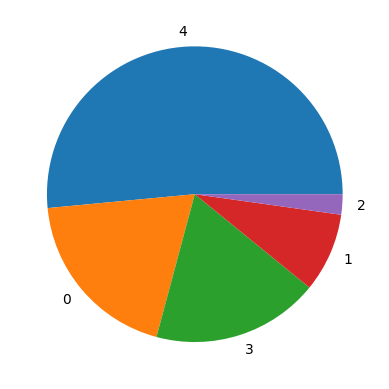

In [41]:
"""Se pone como variable objetivo"""
pd.Series(cl.predict(Xi[mc])).value_counts(1).plot(kind='pie')

In [42]:
"""Densidades de los grupos"""
pd.Series(cl.predict(Xi[mc])).value_counts(1)

4    0.51500
0    0.19325
3    0.18300
1    0.08650
2    0.02225
dtype: float64

In [43]:
"""Seleccionamos cuales son las mejores variables"""
sk = SelectKBest(k=2) #seleccionamos el numero deseado
sk.fit(Xi[mc],cl.predict(Xi[mc]))

SelectKBest(k=2)

In [44]:
"""Creamos una lista con lo mejores """
best = [v for v,i in zip(mc,sk.get_support()) if i]

In [45]:
best

['monto_prom_ult_mes', 'num_txn_ult_mes']

## Cambio de espacios

In [46]:
Xi[um] = X[um]


In [47]:
"""Muestra para visualizar los cluster, sirve como auxiliar"""
x = Xi.sample(n=500).reset_index(drop=True)

### PCA $\mathcal{X}\to\mathcal{X}_p$

In [48]:
"""Creamos el espacio de componenetes principales"""
sc = StandardScaler()
pca = PCA(n_components=2) #Reducimos a dos dimensiones
Xp = pd.DataFrame(pca.fit_transform(sc.fit_transform(x[best]))) #creamos el data frame
print(pca.explained_variance_ratio_.cumsum()) #vemos la varianza explicada
Xp

[0.54367001 1.        ]


,0,1
0,-0.638694,-0.620583
1,-0.703651,0.482409
2,1.358699,-0.261356
3,1.449916,-0.100078
4,4.101415,2.186102
...,...,...
495,0.184639,0.127164
496,-0.092682,-0.493275
497,-0.446205,0.561623
498,-0.294224,-0.796723


### MDS $\mathcal{X}\to\mathcal{X}_m$

In [49]:
"""Creamos el espacio de mds"""
sc = MinMaxScaler()
mds = MDS(n_components=2,n_jobs=-1) #con 2 dimensiones
Xm = pd.DataFrame(mds.fit_transform(sc.fit_transform(x[best]))) #creamos el df
Xm

,0,1
0,0.094942,0.083505
1,0.103594,-0.080838
2,-0.200065,0.056051
3,-0.213654,0.033304
4,-0.605743,-0.274025
...,...,...
495,-0.027144,-0.016723
496,0.014274,0.071665
497,0.065544,-0.089256
498,0.044256,0.114046


### t-SNE $\mathcal{X}\to\mathcal{X}_t$

Distribucion de probabilidad en un espacio mas chico

In [50]:
"""Creamos el espacio de tsne"""
sc = MinMaxScaler()
tsne = TSNE(n_components=2,n_jobs=-1,perplexity=15) #con dos dimensiones, el hiperparametreo de perplexity es la clave para que quede mejor
Xt = pd.DataFrame(tsne.fit_transform(sc.fit_transform(x[best])))
Xt

/Users/jesusarredondo/Documents/Diplomado Ciencia de Datos/Modulo5/mod5/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Users/jesusarredondo/Documents/Diplomado Ciencia de Datos/Modulo5/mod5/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



,0,1
0,16.207335,29.994249
1,15.848766,-16.670671
2,-28.698833,-2.276367
3,-29.547098,-3.678946
4,-36.402992,-17.609026
...,...,...
495,-2.820789,-6.788137
496,5.504240,17.821226
497,11.080318,-15.670281
498,8.846422,30.393269


## Visualización preliminar

### Vectores

In [51]:
"""Grafica de PCA"""
Xp.iplot(kind='scatter',x=0,y=1,mode='markers',color='purple')

In [52]:
"""Gráfica MDS"""
Xm.iplot(kind='scatter',x=0,y=1,mode='markers',color='purple')

In [53]:
"""Gráfica TSNE"""
Xt.iplot(kind='scatter',x=0,y=1,mode='markers',color='purple')

### Densidad

<AxesSubplot: xlabel='0', ylabel='1'>

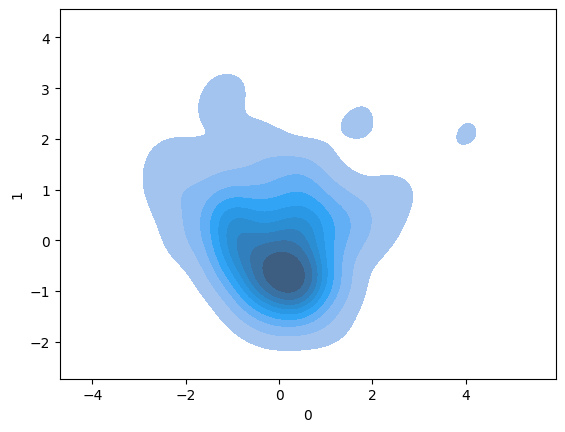

In [54]:
"""Grafica de densidad, sirve para apreciar el numero de cluster posibles aprior- PCA"""
sns.kdeplot(data=Xp,x=0,y=1,fill=True)

<AxesSubplot: xlabel='0', ylabel='1'>

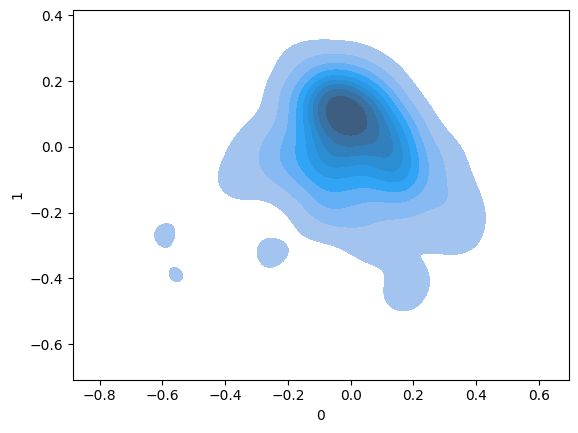

In [55]:
"""MDS"""
sns.kdeplot(data=Xm,x=0,y=1,fill=True)

<AxesSubplot: xlabel='0', ylabel='1'>

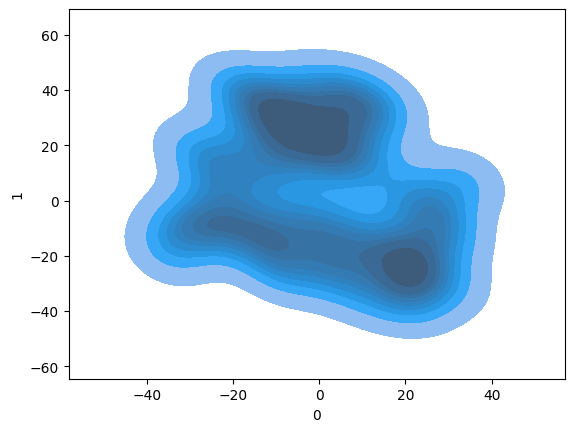

In [56]:
"""TSNE"""
sns.kdeplot(data=Xt,x=0,y=1,fill=True)

## Clustering

In [57]:
sc = MinMaxScaler()
Xs = pd.DataFrame(sc.fit_transform(x[best]),columns=best)

### Agglomerativo

In [58]:
sil = pd.DataFrame(map(lambda k:(k,silhouette_score(Xs,
                                              AgglomerativeClustering(n_clusters=k).fit_predict(Xs))),
                 range(2,10)),columns=['k','sil']).set_index('k')
sil.iplot(kind='line',mode='lines+markers',color='purple') #Graficamos la silueta, entre mas cercana a uno mejor

In [59]:
k = 3 #numero de clusters
tipo = 'agg'
agg = AgglomerativeClustering(n_clusters=k)
x[f'cl_{tipo}']=Xp[f'cl_{tipo}']=Xm[f'cl_{tipo}']=Xt[f'cl_{tipo}'] =agg.fit_predict(Xs[best])

### K-Medias

In [60]:
sil = pd.DataFrame(map(lambda k:(k,silhouette_score(Xs,
                                              KMeans(n_clusters=k,max_iter=1000).fit_predict(Xs))),
                 range(2,10)),columns=['k','sil']).set_index('k')
sil.iplot(kind='line',mode='lines+markers',color='purple')

In [61]:
k = 3
tipo = 'kme'
kme = KMeans(n_clusters=k,max_iter=1000)
x[f'cl_{tipo}']=Xp[f'cl_{tipo}']=Xm[f'cl_{tipo}']=Xt[f'cl_{tipo}'] =kme.fit_predict(Xs[best])

### Modelos Gaussianos Mixtos

In [62]:
sil = pd.DataFrame(map(lambda k:(k,silhouette_score(Xs,
                                              GaussianMixture(n_components=k,max_iter=1000).fit_predict(Xs))),
                 range(2,10)),columns=['k','sil']).set_index('k')
sil.iplot(kind='line',mode='lines+markers',color='purple')

In [63]:
k = 3
tipo = 'gmm'
gmm = GaussianMixture(n_components=k,max_iter=1000)
x[f'cl_{tipo}']=Xp[f'cl_{tipo}']=Xm[f'cl_{tipo}']=Xt[f'cl_{tipo}'] =gmm.fit_predict(Xs[best])

### Selección final

In [64]:
"""Seleccionamos el modelo que tenga mejor silueta global"""
varcl = sorted(x.filter(like='cl_'))
for v in varcl:
    Xp[v] = Xp[v].astype(str)
    Xm[v] = Xm[v].astype(str)
    Xt[v] = Xt[v].astype(str)
    x[v] = x[v].astype(str)
    
pd.DataFrame(map(lambda cl:(cl,silhouette_score(Xs,x[cl])),varcl),columns=['cluster','sil']).iplot(kind='bar',categories='cluster')

In [83]:
mejor = 'gmm'

## Visualización con cluster

/Users/jesusarredondo/Documents/Diplomado Ciencia de Datos/Modulo5/mod5/lib/python3.9/site-packages/cufflinks/plotlytools.py:807: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.

/Users/jesusarredondo/Documents/Diplomado Ciencia de Datos/Modulo5/mod5/lib/python3.9/site-packages/cufflinks/plotlytools.py:810: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.



<AxesSubplot: xlabel='0', ylabel='1'>

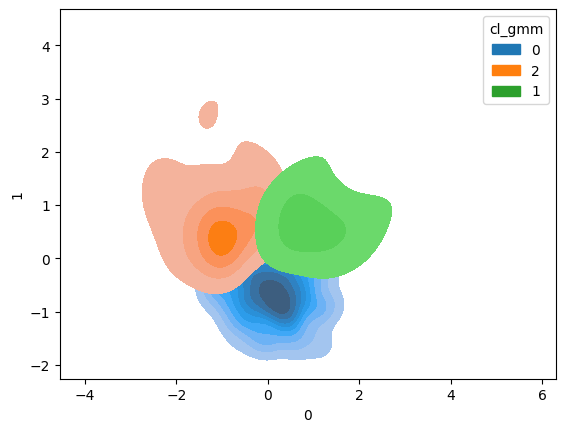

In [84]:
Xp.iplot(kind='scatter',x=0,y=1,mode='markers',categories=f'cl_{mejor}')
sns.kdeplot(data=Xp,x=0,y=1,fill=True,hue=f'cl_{mejor}')

/Users/jesusarredondo/Documents/Diplomado Ciencia de Datos/Modulo5/mod5/lib/python3.9/site-packages/cufflinks/plotlytools.py:807: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.

/Users/jesusarredondo/Documents/Diplomado Ciencia de Datos/Modulo5/mod5/lib/python3.9/site-packages/cufflinks/plotlytools.py:810: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.



<AxesSubplot: xlabel='0', ylabel='1'>

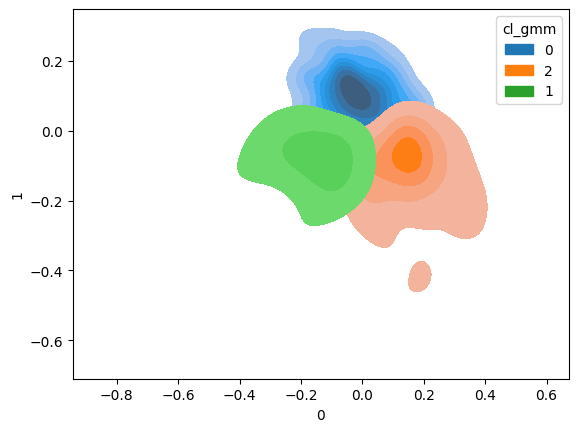

In [85]:
Xm.iplot(kind='scatter',x=0,y=1,mode='markers',categories=f'cl_{mejor}')
sns.kdeplot(data=Xm,x=0,y=1,fill=True,hue=f'cl_{mejor}')

/Users/jesusarredondo/Documents/Diplomado Ciencia de Datos/Modulo5/mod5/lib/python3.9/site-packages/cufflinks/plotlytools.py:807: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.

/Users/jesusarredondo/Documents/Diplomado Ciencia de Datos/Modulo5/mod5/lib/python3.9/site-packages/cufflinks/plotlytools.py:810: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.



<AxesSubplot: xlabel='0', ylabel='1'>

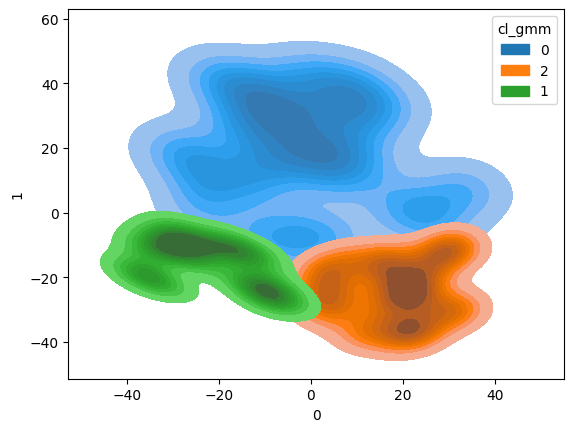

In [86]:
Xt.iplot(kind='scatter',x=0,y=1,mode='markers',categories=f'cl_{mejor}')
sns.kdeplot(data=Xt,x=0,y=1,fill=True,hue=f'cl_{mejor}')

## Perfilamiento

### Continuo

In [87]:
pd.DataFrame(map(lambda v:(v,
              kruskal(*[d[v].reset_index(drop=True) for cl,d in x[[f'cl_{mejor}',v]].groupby(f'cl_{mejor}')]).pvalue),best),
             columns=['variable','p-value']).round(2)

,variable,p-value
0,monto_prom_ult_mes,0.0
1,num_txn_ult_mes,0.0


monto_prom_ult_mes


group1,group2,meandiff,p-adj,lower,upper,reject
0,1,-33.6254,0.0,-36.496,-30.7548,True
0,2,-29.1691,0.0,-32.9145,-25.4236,True
1,2,4.4563,0.0064,1.0442,7.8685,True


num_txn_ult_mes


group1,group2,meandiff,p-adj,lower,upper,reject
0,1,-5.0421,0.3348,-13.4283,3.3442,False
0,2,92.6394,0.0,81.6971,103.5817,True
1,2,97.6815,0.0,87.7129,107.65,True


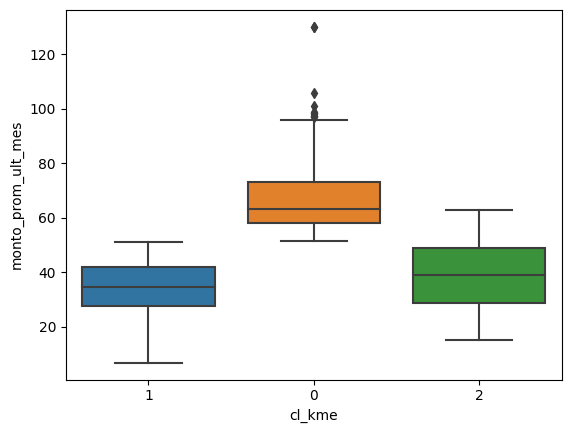

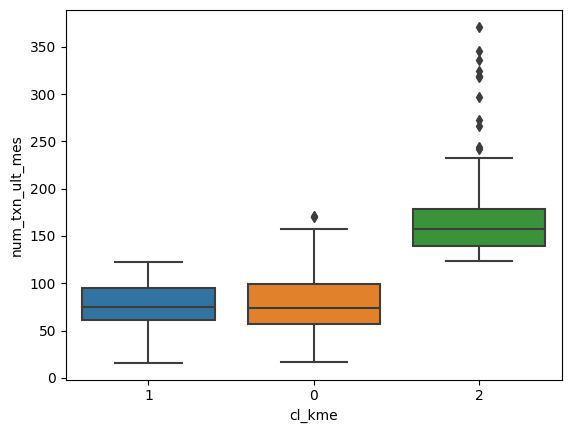

In [88]:
for v in best:
    print(v)
    display(MultiComparison(x[v],x['cl_kme']).tukeyhsd().summary())
    plt.figure()
    sns.boxplot(data=x,y=v,x='cl_kme')

### Discreto

In [89]:
aux = x[um+[f'cl_{mejor}']].merge(Xd[um+varn],on=um,how='inner')

In [90]:
for v in varn:
    piv = aux.pivot_table(index=v,columns=f'cl_{mejor}',values=um[0],aggfunc='count',fill_value=0)
    piv/=piv.sum()
    piv.T.iplot(kind='bar',barmode='stack',title=v)

## Arquetipos

In [91]:
display(x[best+[f'cl_{mejor}']].groupby(f'cl_{mejor}').mean())
display(x[best].mean().to_frame().T)

,monto_prom_ult_mes,num_txn_ult_mes
cl_gmm,,
0,35.618977,76.037415
1,38.657836,178.848101
2,70.113810,86.291339


,monto_prom_ult_mes,num_txn_ult_mes
0,44.860805,94.886


In [92]:
pd.set_option('display.max_colwidth',None)

In [93]:
x[um+best].loc[x[f'cl_{mejor}']=='0'].sample(3)

,id_txn,monto_prom_ult_mes,num_txn_ult_mes
51,17285182,32.929079,76.0
411,11883257,51.508714,70.0
480,21010895,43.982941,68.0


In [94]:
from sklearn.tree import DecisionTreeClassifier,plot_tree

In [95]:
dt = DecisionTreeClassifier()

In [96]:
dt.fit(x[best],x[f'cl_{mejor}'])

DecisionTreeClassifier()

[Text(0.525, 0.9375, 'monto_prom_ult_mes <= 55.156\ngini = 0.565\nsamples = 500\nvalue = [294, 79, 127]'),
 Text(0.25, 0.8125, 'num_txn_ult_mes <= 127.5\ngini = 0.347\nsamples = 371\nvalue = [291, 72, 8]'),
 Text(0.1, 0.6875, 'monto_prom_ult_mes <= 51.688\ngini = 0.047\nsamples = 293\nvalue = [286, 0, 7]'),
 Text(0.05, 0.5625, 'gini = 0.0\nsamples = 271\nvalue = [271, 0, 0]'),
 Text(0.15, 0.5625, 'num_txn_ult_mes <= 93.0\ngini = 0.434\nsamples = 22\nvalue = [15, 0, 7]'),
 Text(0.1, 0.4375, 'gini = 0.0\nsamples = 15\nvalue = [15, 0, 0]'),
 Text(0.2, 0.4375, 'gini = 0.0\nsamples = 7\nvalue = [0, 0, 7]'),
 Text(0.4, 0.6875, 'num_txn_ult_mes <= 138.0\ngini = 0.144\nsamples = 78\nvalue = [5, 72, 1]'),
 Text(0.35, 0.5625, 'monto_prom_ult_mes <= 31.947\ngini = 0.46\nsamples = 19\nvalue = [5, 13, 1]'),
 Text(0.3, 0.4375, 'gini = 0.0\nsamples = 3\nvalue = [3, 0, 0]'),
 Text(0.4, 0.4375, 'num_txn_ult_mes <= 136.0\ngini = 0.32\nsamples = 16\nvalue = [2, 13, 1]'),
 Text(0.35, 0.3125, 'monto_prom_u

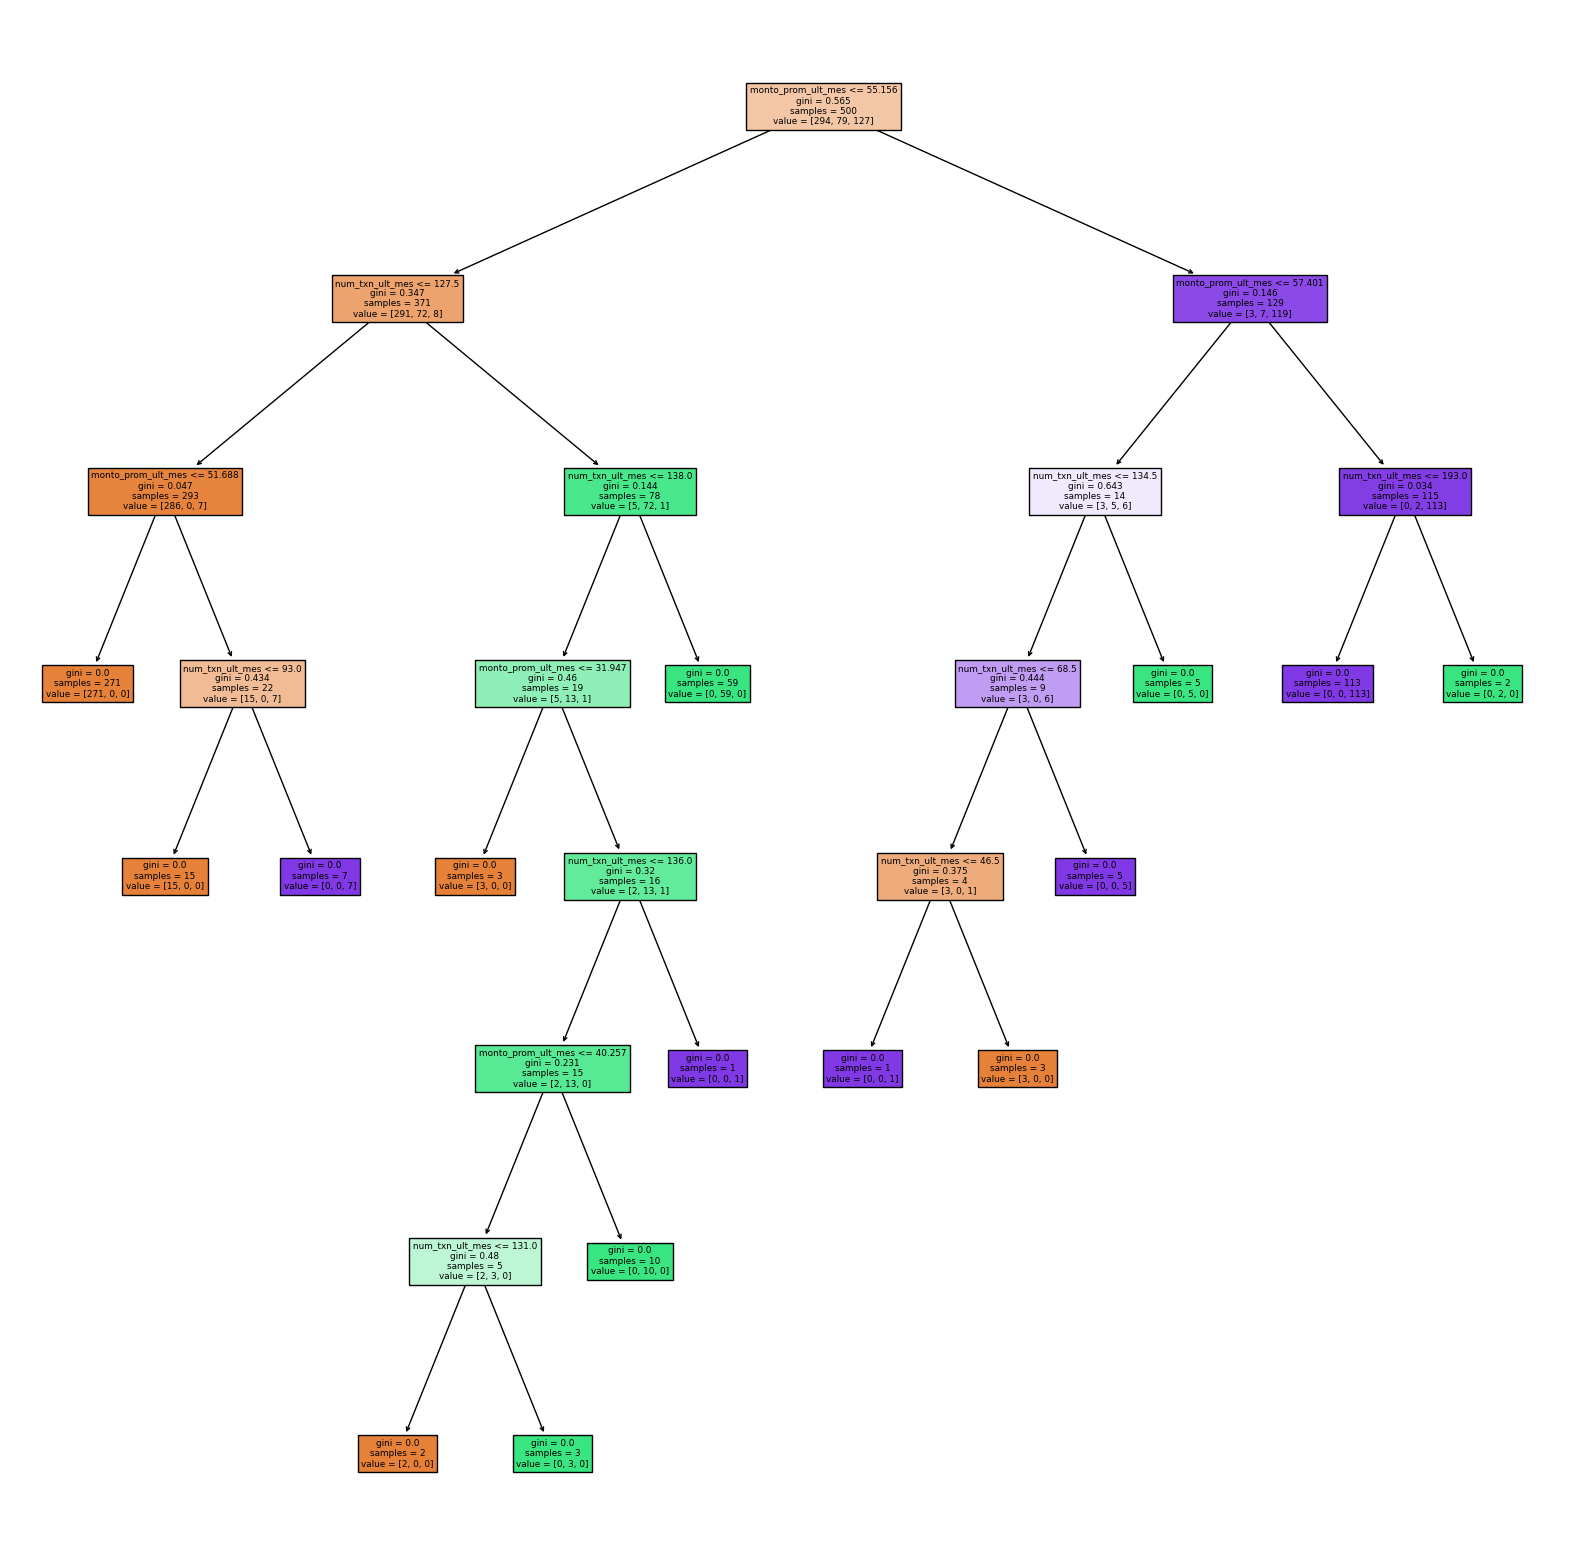

In [97]:
plt.figure(figsize=(20,20))
plot_tree(dt,feature_names=best,filled=True)

In [98]:
aux = x[um+[f'cl_{mejor}']].merge(df[um+['ts']],on=um,how='inner')

In [99]:
aux['ts'] = aux['ts'].map(lambda x:x.strftime('%Y'))

In [100]:
"""Estabilidad en el tiempo, no es estable"""
piv = aux.pivot_table(index=f'cl_{mejor}',columns='ts',values=um[0],aggfunc='count',fill_value=0)
piv/=piv.sum()
piv.T.iplot(kind='bar',barmode='stack')